# Diffusion Recolorize

## Install package `kaggle`

In [1]:
!pip3 install kaggle

## Download Scripts

In [ ]:
# Download Packages 📦

CURRENT_LINK = "https://raw.githubusercontent.com/ggonzalesd/diffusion-recolorize/refs/heads/main"

SCRIPTS = [
  'm_patchattention.py', 'm_convolutional.py', 'm_dataset.py',
  'm_down.py', 'm_model.py', 'm_unet.py',
  'm_up.py', 'm_utils.py', 'm_embedding.py'
]

for modulename in SCRIPTS:
  print(f'Download {modulename} 📦')
  !curl {CURRENT_LINK}/{modulename} --output {modulename} > /dev/null 2>&1

Download m_selfattention.py 📦
Download m_convolutional.py 📦
Download m_dataset.py 📦
Download m_down.py 📦
Download m_model.py 📦
Download m_unet.py 📦
Download m_up.py 📦
Download m_utils.py 📦
Download m_embedding.py 📦


## Loading packages

In [1]:
import numpy as np
import torch, os, glob, random
from torch import Tensor, nn, optim
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torch.nn.functional as F

from m_dataset import LandspaceDataset
from m_model import Recolorate
from m_utils import cosine_scheduler, sample_timesteps, noise_image

from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
from PIL import Image

/tmp/ipykernel_8339/3491396565.py:12: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## Downloading Dataset

In [6]:
!kaggle datasets download -d arnaud58/landscape-pictures
!mkdir -p dataset/
!unzip landscape-pictures.zip -d dataset | tqdm --desc extracted --unit files --unit_scale --total 4320 > /dev/null

Dataset URL: https://www.kaggle.com/datasets/arnaud58/landscape-pictures
License(s): CC0-1.0
100% 620M/620M [00:27<00:00, 33.0MB/s]
100% 620M/620M [00:27<00:00, 23.9MB/s]
extracted: 100% 4.32k/4.32k [00:06<00:00, 719files/s]


### Preprocessing Images

Preprocessing:   0%|          | 0/4319 [00:00<?, ?it/s]

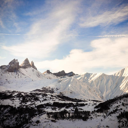

In [7]:
!mkdir -p postprocessing/

filenames = glob.glob(os.path.join('dataset', '*'))
pbar = tqdm(total=len(filenames), desc='Preprocessing', colour='magenta')
for index, filename in enumerate(filenames):
  pbar.update(1)

  image = Image.open(filename)
  w, h = image.size
  ww = int(128 * w / h)
  if w < h:
    continue
  image = image.resize((ww, 128))

  offset = random.randint(0, ww - 128)

  image = image.crop([offset, 0, offset+128, 128])

  image.save(os.path.join('postprocessing', f'img-{index}.jpg'))
pbar.close()
image

In [8]:
filenames = glob.glob(os.path.join('postprocessing', '*.jpg'))

pbar = tqdm(total=len(filenames), desc='Reading Images')
mean = np.zeros((3,))
std = np.zeros((3,))
for filename in filenames:
  pbar.update(1)
  image = Image.open(filename).convert('RGB')
  image = np.array(image, dtype=np.float32) / 255

  mean += image.mean((0, 1))
  std += image.std((0, 1))

pbar.close()
mean = mean / len(filenames)
std = std / len(filenames)

np.save(os.path.join('postprocessing', 'mean_std.npy'), np.stack([mean, std]))

print('mean', mean)
print('std', std)

Reading Images:   0%|          | 0/3924 [00:00<?, ?it/s]

mean [0.45672647 0.48508492 0.47636758]
std [0.22412057 0.21338072 0.24737799]


In [2]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
PATH = os.path.join('postprocessing')
W_SIZE = 128
H_SIZE = 128
BATCH = 8 #16
SHUFFLE = True
STEPS = 1000
EMBEDDING = 128
EPOCHS = 10

transform = T.Compose([
  T.ToTensor(),
  T.RandomResizedCrop((W_SIZE, H_SIZE), (0.85, 1.0), interpolation=T.InterpolationMode.NEAREST),
  T.RandomHorizontalFlip(0.5),
])

dataset = LandspaceDataset(PATH, transform)
dataloader = DataLoader(dataset, BATCH, SHUFFLE, drop_last=True)

print('Dataset:', dataset)
print('Dataloader:', len(dataloader))

Dataset: <LandscapeDataset len:3924>
Dataloader: 490


In [3]:
model = Recolorate(STEPS, EMBEDDING, W_SIZE, H_SIZE, DEVICE).to(DEVICE)

In [4]:
model.load_state_dict(torch.load('model-trained.pt', weights_only=True, map_location=DEVICE))

<All keys matched successfully>

In [4]:
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-8)
loss_fn = nn.MSELoss()
scheduler = cosine_scheduler(STEPS, DEVICE)

In [5]:
!mkdir -p output
def plot_images(x:Tensor) -> Tensor:
  length = x.shape[0]
  plt.figure(figsize=(length*2, 1*2))
  plt.axis('off')
  for i in range(length):
    plt.subplot(1, length, 1+i)
    plt.axis('off')
    plt.imshow(x.detach().cpu()[i].moveaxis(0, -1).numpy())
  plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 1e-1)
  plt.show()

def distribution_to_image(x:Tensor, tag:str=''):
  x = torch.clone((x.detach().cpu()*dataset.std.cpu() + dataset.mean.cpu()))
  x = x.clamp(0.0, 1.0)
  x = (x * 255).type(torch.uint8)
  image = Image.fromarray(x[0].moveaxis(0, -1).numpy())
  image.save(f'output/img-{tag}.png')
  return x

def genereate_image_timesteps(model:Recolorate, scheduler:tuple[Tensor, Tensor, Tensor], src:Tensor, device='cpu'):
  alpha_, beta_, alpha_hat_ = scheduler

  generations = []

  model.eval()
  model.to(device)
  with torch.inference_mode():
    x = torch.randn((1, 3, 128, 128), device=device)
    generations.append(distribution_to_image(x, '0'))
    pbar = tqdm(total=1000, desc=f'Sampling', position=0, colour='yellow')
    pbar.update(1)

    for i in reversed(range(1, 1000)):
      t = (torch.ones(1, device=device) * i).long()
      predicted:Tensor = model(x, t, src)
      alpha = alpha_[t][:, None, None, None]
      alpha_hat = alpha_hat_[t][:, None, None, None]
      beta = beta_[t][:, None, None, None]
      if i > 1:
        noise = torch.randn_like(x, device=device)
      else:
        noise = torch.zeros_like(x, device=device)

      x = 1 / torch.sqrt(alpha) * (x - ((1-alpha)/torch.sqrt(1 - alpha_hat))*predicted)
      if i > 1:
        x = x.clamp(-2.25, 2.25)
      x = x + torch.sqrt(beta)*noise

      if (i-1) % 50 == 0:
        generations.append(distribution_to_image(x, f'{1000-i+1}'))
      pbar.update(1)
    pbar.close()

  x = torch.cat(generations, dim=0)

  plot_images(x)

  return x

src = dataset[0][1].unsqueeze(0).to(DEVICE)
data = genereate_image_timesteps(model, scheduler, src, DEVICE)

Sampling:  40%|████      | 405/1000 [08:22<13:49,  1.39s/it]

KeyboardInterrupt: 

In [7]:
for epoch in range(EPOCHS):
  total = 0
  total_loss = 0

  model.train()
  pbar = tqdm(total=len(dataloader), desc='Train', colour='yellow')
  for original, gray in dataloader:
    original = original.to(DEVICE)
    gray = gray.to(DEVICE)

    t = sample_timesteps(BATCH, STEPS, DEVICE)
    sampled, noise = noise_image(original, t, scheduler, DEVICE)

    predicted = model(sampled, t, gray if random.random() < 0.15 else None)
    loss:Tensor = loss_fn(noise, predicted)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item() * original.shape[0]
    total += original.shape[0]

    pbar.set_postfix(MSE=loss.item())
    pbar.update(1)

  torch.save(model.state_dict(), f'model-{epoch+1}.pt')

  total_loss = total_loss / total
  pbar.set_postfix(MSE=total_loss)
  pbar.close()

  src = dataset[0][1].unsqueeze(0).to(DEVICE)
  data = genereate_image_timesteps(model, scheduler, src, DEVICE)


Train:   0%|          | 0/490 [00:14<?, ?it/s]






























































































































































































































































































Sampling:  40%|████      | 405/1000 [1:18:25<1:55:12, 11.62s/it]


KeyboardInterrupt: 

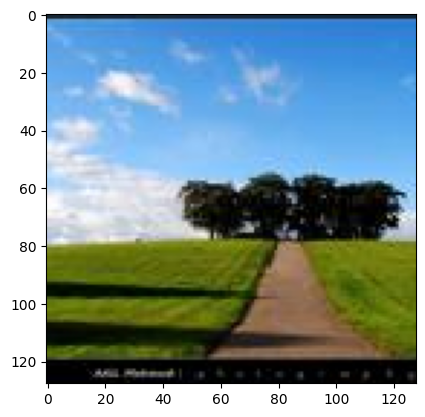

In [6]:
plt.imshow((dataset[0][0]*dataset.std + dataset.mean).moveaxis(0, -1).numpy())
plt.show()

In [ ]:
torch.save(model.state_dict(), 'model-2.pt')